In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#데이터 셋 load
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

#압축 풀기
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

#라이브러리 import
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img , img_to_array , array_to_img
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import random

input_dir = "images/"
target_dir = "annotations/trimaps/"

# 데이터 처리를 위한 준비
input_img_paths =sorted([os.path.join(input_dir , fname )for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir , fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

--2024-10-11 10:14:10--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-10-11 10:14:10--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-10-11 10:14:11--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [3]:
# Load Dataset and Preprocessing
print(len(input_img_paths))
print(len(target_img_paths))

img_size=(160,160)
n_class = 3
batch_size = 48

7390
7390


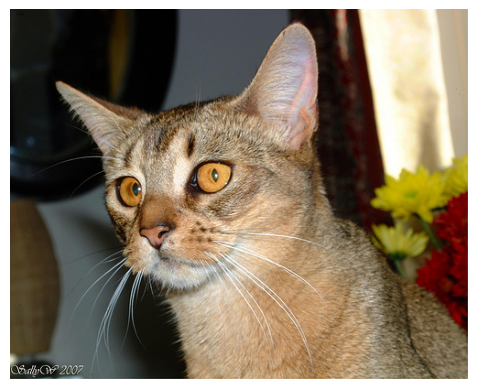

In [4]:
plt.axis('off')
plt.imshow(load_img(input_img_paths[10]))

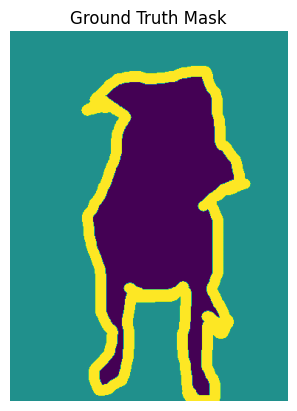

In [20]:
# Ground truth에 대한 이미지를 화면에 표시하는 함수
def display_target(img):
  normalizd_img =(img.astype('uint') -1)*127
  plt.axis("off")
  plt.title('Ground Truth Mask')
  plt.imshow(normalizd_img[:, : ,0])

img = load_img(target_img_paths[10], color_mode = 'grayscale')
img = img_to_array(img)
display_target(img)

In [6]:
# OxfordPets Dataset Class 정의
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size,img_size,img_paths,label_paths):
      self.batch_size=batch_size
      self.img_size=img_size
      self.img_paths=img_paths
      self.label_paths=label_paths

    def __len__(self):
      return len(self.label_paths)//self.batch_size

    def __getitem__(self,idx):
        i=idx*self.batch_size
        batch_img_paths=self.img_paths[i:i+self.batch_size]
        batch_label_paths=self.label_paths[i:i+self.batch_size]
        x=np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
        for j,path in enumerate(batch_img_paths):
          img = load_img(path, target_size = self.img_size)
          x[j] = img

        y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
        for j,path in enumerate(batch_label_paths):
          img = load_img(path,target_size=self.img_size,color_mode="grayscale")
          y[j]=np.expand_dims(img,2)
          y[j] -=1


        return x,y


In [7]:
# Conv2D Block
def conv2d_block(input_tensor, n_filters, kernel_size=3):
  x = input_tensor
  for i in range(2):
    x = layers.SeparableConv2D(filters=n_filters,
                      kernel_size=(kernel_size, kernel_size),
                      depthwise_initializer='glorot_uniform',pointwise_initializer='glorot_uniform', padding = 'same')(x)
    x = layers.Activation('relu')(x)
  return x

# Encoder Block, Encoder
def encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = layers.MaxPooling2D(pool_size=pool_size)(f)
  p = layers.Dropout(0.3)(p)
  return f, p

def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
  return p4, (f1, f2, f3, f4)

In [8]:
# Bottle Neck (Skip-connection)
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

# Decoder block, Decoder
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding="same")(inputs)
  c = layers.concatenate([u, conv_output])
  c = layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c

def decoder(inputs, convs, output_channels=3):
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation="softmax")(c9)
  return outputs

# make_model : 전체 모델(U-Net) 구현 함수
def make_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size+(3,))
  encoder_output, convs = encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  outputs = decoder(bottle_neck, convs, 3)
  model = keras.Model(inputs=inputs, outputs=outputs, name="U-Net")
  return model

In [9]:
# 모델 선언
model = make_model(img_size, n_class)

# train img, label shuffle
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# train : test = 8 : 2
test_samples=int(len(input_img_paths)*0.2)
train_img_paths = input_img_paths[:-test_samples]
train_label_paths = target_img_paths[:-test_samples]
test_img_paths = input_img_paths[-test_samples:]
test_label_paths = target_img_paths[-test_samples:]

train_gen = OxfordPets(batch_size,img_size,train_img_paths,train_label_paths)
test_gen = OxfordPets(batch_size,img_size,test_img_paths,test_label_paths)

In [10]:
# 모델 Training
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model_path = "/content/drive/MyDrive/Colab Notebooks/딥러닝응용/U-Net/oxford_segmentation.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
]


from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model(model_path)

# 30 epoch 학습
history = model.fit(train_gen, epochs=30, validation_data=test_gen, callbacks=callbacks, initial_epoch=2)
# test data prediction
preds = model.predict(test_gen)

Epoch 3/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6265 - loss: 0.7972 - val_accuracy: 0.6637 - val_loss: 0.7421
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6813 - loss: 0.7243 - val_accuracy: 0.7159 - val_loss: 0.6636
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7312 - loss: 0.6476 - val_accuracy: 0.7473 - val_loss: 0.6144
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7543 - loss: 0.6026 - val_accuracy: 0.7802 - val_loss: 0.5521
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7770 - loss: 0.5557 - val_accuracy: 0.8014 - val_loss: 0.4994
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8006 - loss: 0.5042 - val_accuracy: 0.8252 - val_loss: 0.4448
Epoch 9/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8155 - loss: 0.4671 - val_accuracy: 0.8372 - val_loss: 0.4193
Epoch 10/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8315 - loss: 0.4321 - val_accuracy: 0.83

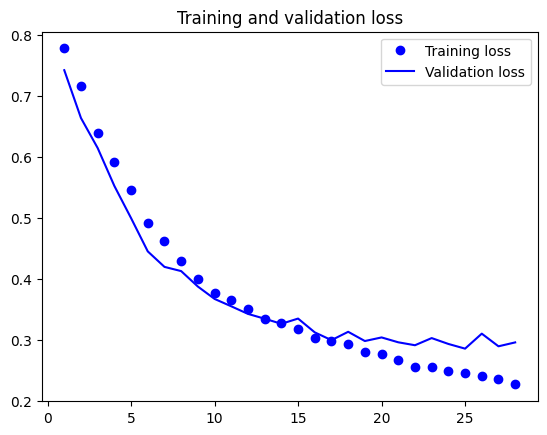

In [12]:
# Train loss, Validation loss 그래프 확인
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


In [23]:
def inference_result(sample_img):

  img1 = load_img(test_img_paths[sample_img], target_size=(160, 160))
  mask = np.argmax(preds[sample_img], axis=-1)  # 마스크 예측값
  mask *= 127  # 마스크 가시화 (색 강도를 위해 스케일링)

  # 타겟 이미지 로드
  target_img = load_img(test_label_paths[sample_img], color_mode="grayscale", target_size=(160, 160))
  target_img = img_to_array(target_img)

  # 1행 3열로 이미지 출력
  plt.figure(figsize=(15, 5))

  # 원본 이미지
  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.title(f'Original Image : test_img {sample_img}')
  plt.imshow(array_to_img(img1))

  # 예측된 마스크
  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.title('Predicted Mask')
  plt.imshow(mask)

  # 타겟 이미지
  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.title('Target Image')
  display_target(target_img)

  # 출력
  plt.show()


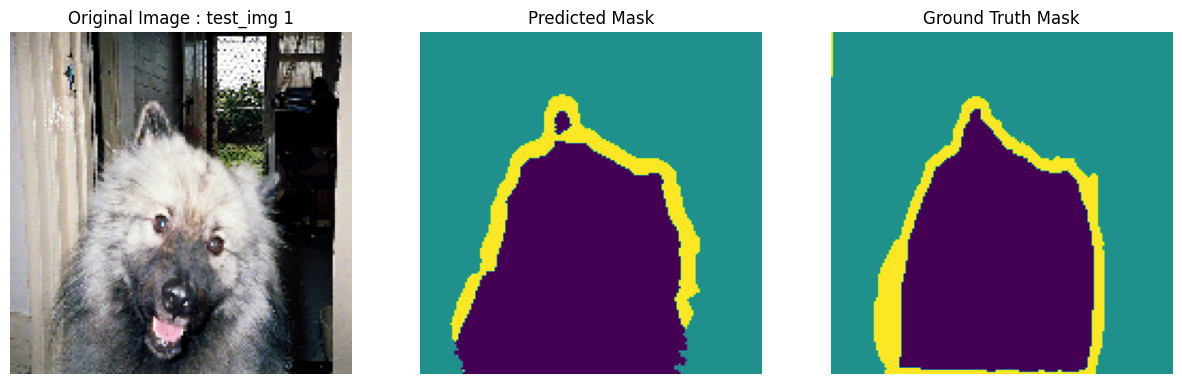

In [24]:
inference_result(1)

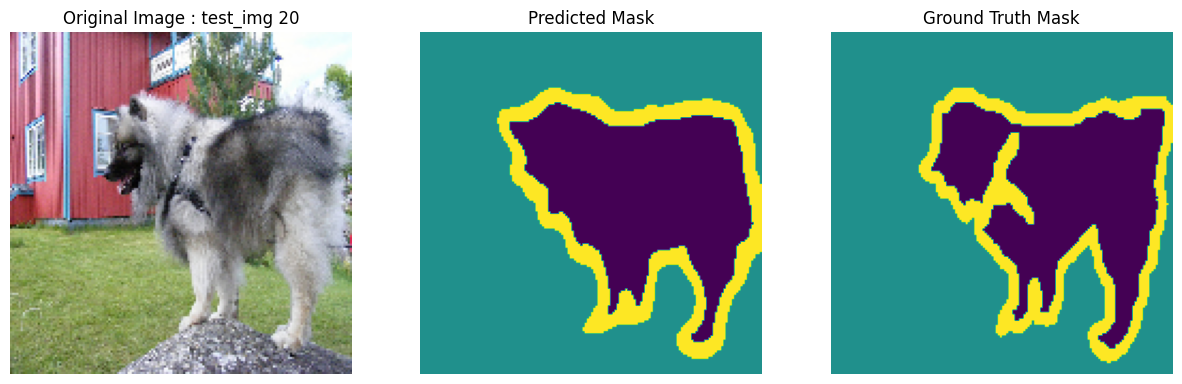

In [26]:
inference_result(20)

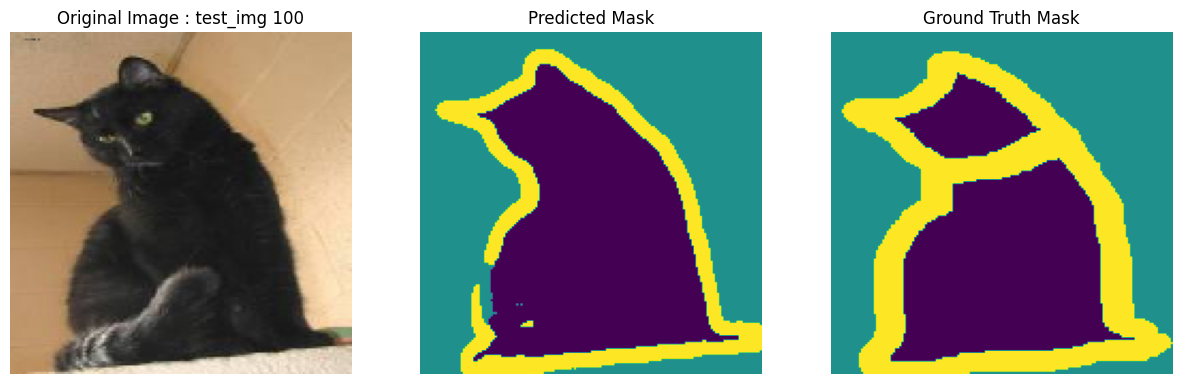

In [27]:
inference_result(100)